In [1]:
from splink.duckdb.duckdb_linker import DuckDBLinker
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
import pandas as pd 
pd.options.display.max_rows = 1000
df = pd.read_parquet("./data/historical_figures_with_errors_50k.parquet")
df.head(5)

,unique_id,cluster,full_name,first_and_surname,first_name,surname,dob,birth_place,postcode_fake,gender,occupation
0,Q2296770-1,Q2296770,"thomas clifford, 1st baron clifford of chudleigh",thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,male,politician
1,Q2296770-2,Q2296770,thomas of chudleigh,thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,male,politician
2,Q2296770-3,Q2296770,tom 1st baron clifford of chudleigh,tom chudleigh,tom,chudleigh,1630-08-01,devon,tq13 8df,male,politician
3,Q2296770-4,Q2296770,thomas 1st chudleigh,thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8hu,None,politician
4,Q2296770-5,Q2296770,"thomas clifford, 1st baron chudleigh",thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,None,politician


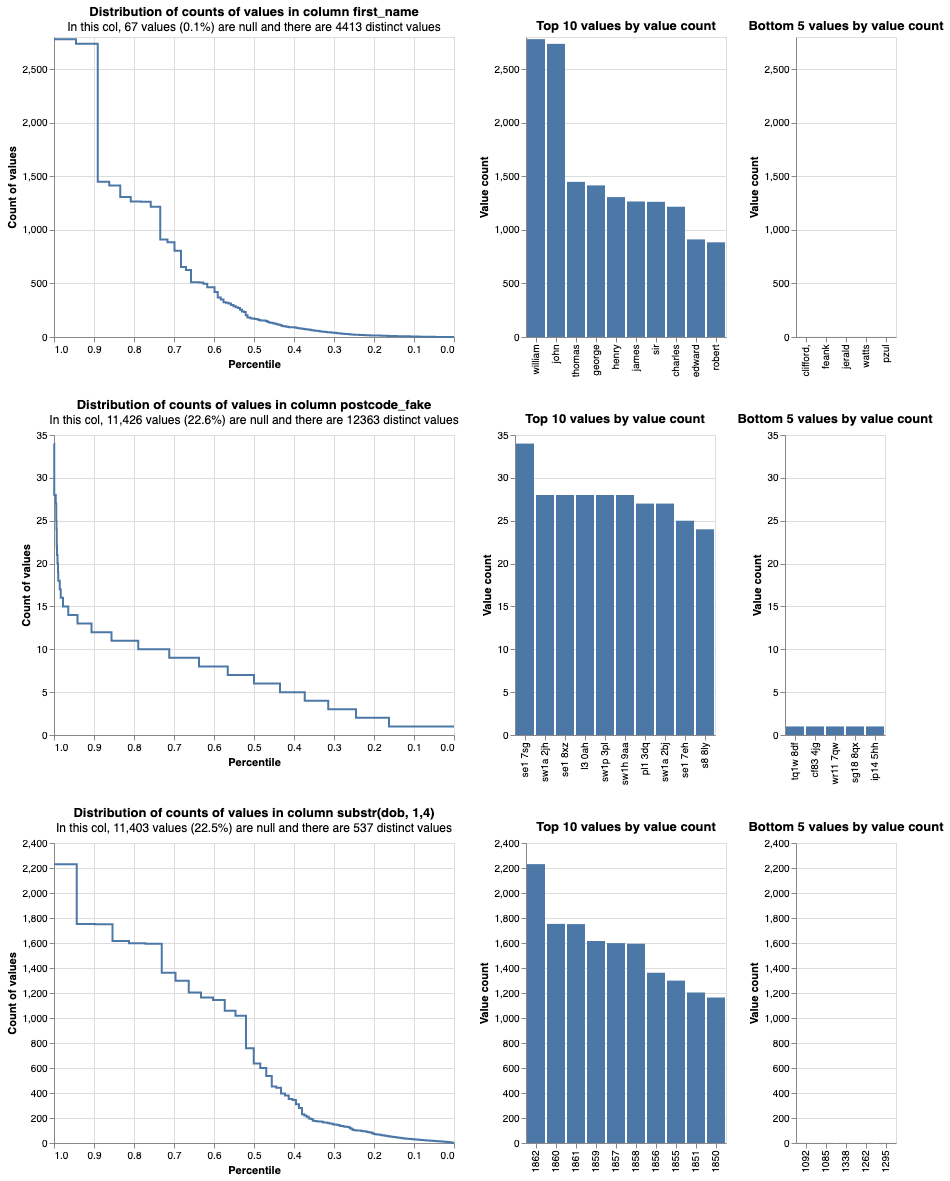

In [3]:
# Initialise the linker, passing in the input dataset(s)
settings = {"link_type": "dedupe_only"}
linker = DuckDBLinker(df, settings, connection=":temporary:")

import altair as alt
alt.renderers.enable('mimetype')
linker.profile_columns(["first_name", "postcode_fake", "substr(dob, 1,4)"], top_n=10, bottom_n=5)

In [4]:
linker.count_num_comparisons_from_blocking_rule("l.first_name = r.first_name")

16372982

In [5]:
linker.count_num_comparisons_from_blocking_rule("l.first_name = r.first_name and l.surname = r.surname")

243656

In [6]:
linker.count_num_comparisons_from_blocking_rule("l.dob = r.dob")

1549081

In [7]:
import splink.duckdb.duckdb_comparison_library as cl

settings = {
    "probability_two_random_records_match": 9/50_000,
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name and l.surname = r.surname",
        "l.surname = r.surname and l.dob = r.dob",
        "l.first_name = r.first_name and l.dob = r.dob",
        "l.postcode_fake = r.postcode_fake and l.first_name = r.first_name",
    ],
    "comparisons": [
        cl.jaccard_at_thresholds("first_name", [0.9, 0.5], term_frequency_adjustments=False),
        cl.jaccard_at_thresholds("surname", [0.9, 0.5], term_frequency_adjustments=False),
        cl.levenshtein_at_thresholds("dob", [1,2], term_frequency_adjustments=False),
        cl.levenshtein_at_thresholds("postcode_fake", 2),
        cl.exact_match("birth_place", term_frequency_adjustments=False),
        cl.exact_match("occupation",  term_frequency_adjustments=False),
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
    "max_iterations": 10,
    "em_convergence": 0.01
}

In [8]:
linker.initialise_settings(settings)

In [9]:
linker.estimate_u_using_random_sampling(target_rows=5e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).
    - dob (no m values are trained).
    - postcode_fake (no m values are trained).
    - birth_place (no m values are trained).
    - occupation (no m values are trained).



----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.first_name = r.first_name and l.surname = r.surname

Parameter estimates will be made for the following comparison(s):
    - dob
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - first_name
    - surname

Iteration 1: Largest change in params was -0.529 in probability_two_random_records_match
Iteration 2: Largest change in params was -0.0373 in probability_two_random_records_match
Iteration 3: Largest change in params was 0.0162 in the m_probability of birth_place, level `Exact match`
Iteration 4: Largest change in params was -0.00748 in the m_probability of dob, level `All other comparisons`

EM converged after 4 iterations

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are tra

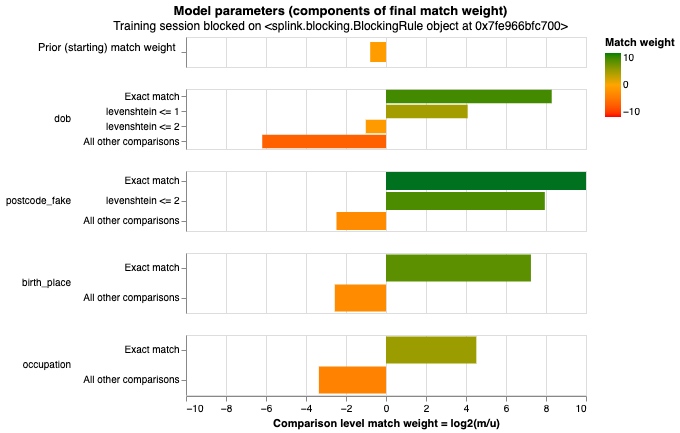

In [10]:
blocking_rule = "l.first_name = r.first_name and l.surname = r.surname"
training_session_names = linker.estimate_parameters_using_expectation_maximisation(blocking_rule)
training_session_names.match_weights_interactive_history_chart()


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.dob = r.dob

Parameter estimates will be made for the following comparison(s):
    - first_name
    - surname
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - dob

Iteration 1: Largest change in params was -0.352 in the m_probability of first_name, level `Exact match`
Iteration 2: Largest change in params was -0.0365 in the m_probability of first_name, level `Exact match`
Iteration 3: Largest change in params was -0.00587 in the m_probability of surname, level `Exact match`

EM converged after 3 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


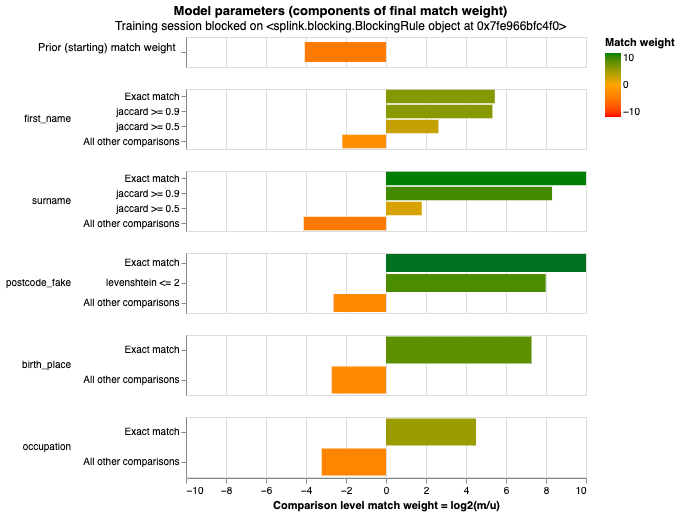

In [11]:
blocking_rule = "l.dob = r.dob"
training_session_dob = linker.estimate_parameters_using_expectation_maximisation(blocking_rule)
training_session_dob.match_weights_interactive_history_chart()

The final match weights can be viewed in the match weights chart:

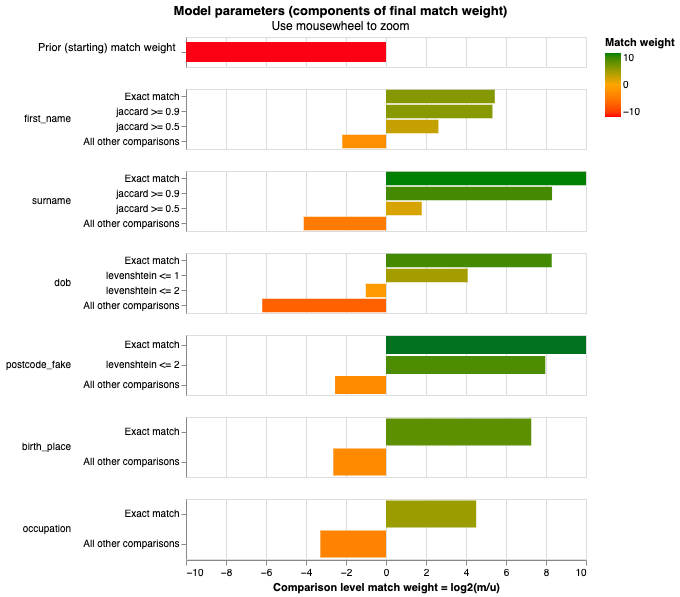

In [12]:
linker.match_weights_chart()

In [13]:
df_predict = linker.predict()
df_e = df_predict.as_pandas_dataframe(limit=5)
df_e

,match_weight,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,bf_first_name,surname_l,surname_r,...,bf_postcode_fake,birth_place_l,birth_place_r,gamma_birth_place,bf_birth_place,occupation_l,occupation_r,gamma_occupation,bf_occupation,match_key
0,19.641479,0.999999,Q2296770-1,Q2296770-14,thomas,thomas,3,43.427885,chudleigh,chudleigh,...,249.467633,devon,NaN,-1,1.000000,politician,politician,1,22.77665,0
1,5.048632,0.970672,Q2296770-10,Q2296770-14,thomas,thomas,3,43.427885,chudleigh,chudleigh,...,0.171118,devon,NaN,-1,1.000000,politician,politician,1,22.77665,0
2,25.497744,1.000000,Q1443188-1,Q1443188-3,frank,frank,3,43.427885,brightman,brightman,...,4874.614882,bristol,"bristol, city of",0,0.160976,liturgist,liturgist,1,22.77665,0
3,25.497744,1.000000,Q1443188-2,Q1443188-3,frank,frank,3,43.427885,brightman,brightman,...,4874.614882,bristol,"bristol, city of",0,0.160976,liturgist,liturgist,1,22.77665,0
4,9.131831,0.998221,Q1443188-4,Q1443188-5,francis,francis,3,43.427885,brightman,brightman,...,0.171118,NaN,"bristol, city of",-1,1.000000,liturgist,liturgist,1,22.77665,0


You can also view rows in this dataset as a waterfall chart as follows:

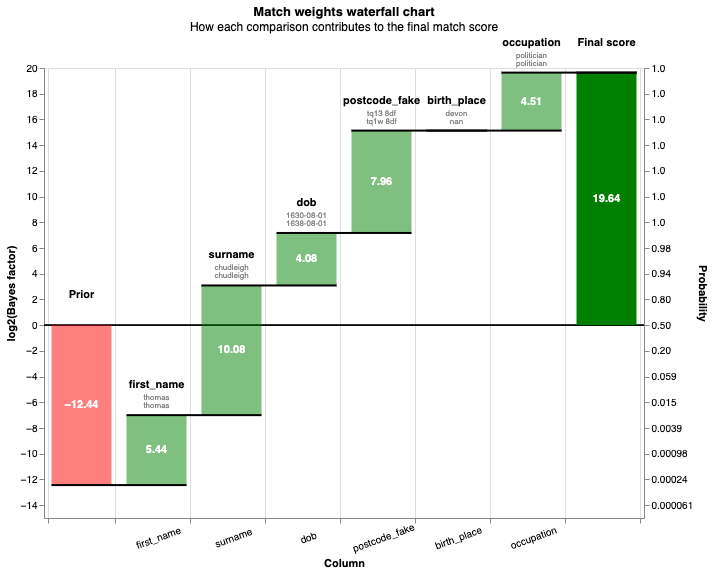

In [14]:
from splink.charts import waterfall_chart
records_to_plot = df_e.to_dict(orient="records")
linker.waterfall_chart(records_to_plot, filter_nulls=False)

In [15]:
clusters = linker.cluster_pairwise_predictions_at_threshold(df_predict, threshold_match_probability=0.95)

Completed iteration 1, root rows count 945
Completed iteration 2, root rows count 312
Completed iteration 3, root rows count 289
Completed iteration 4, root rows count 149
Completed iteration 5, root rows count 77
Completed iteration 6, root rows count 47
Completed iteration 7, root rows count 44
Completed iteration 8, root rows count 19
Completed iteration 9, root rows count 0


In [16]:
linker.cluster_studio_dashboard(df_predict, clusters, "50k_cluster.html", sampling_method='by_cluster_size', overwrite=True)

In [17]:
from IPython.display import IFrame

IFrame(
    src="./50k_cluster.html", width="100%", height=1200
)  